<a href="https://colab.research.google.com/github/danielleitesoares/Work_Sentimental_Analyzer_Of_Restaurant_Issue/blob/main/Analise_dos_Sentimentos_Restaurantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Analise de Sentimentos Restaurantes**
> Equipe: Leonardo Rocha, Paulo Correa e Daniel Soares
> Turma 02





### 0.Importação das Bibliotecas Utilizadas 




In [58]:
# coding = utf-8  
#Bibliotecas Básicas 
import pandas as pd
import numpy as np
import json
import nltk
import time  # avaliar
import sys
import unicodedata
import requests
#Bibliotecas de Gráficos e Relatórios 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling as ppf
from pandas_profiling import ProfileReport

#Bibliotecas de Análise de Sentimentos
import textblob


### 1.Tratamento do dataset-v2.dat

##### 1.1. Abrindo o Dataset 

In [59]:
nltk.download('punkt')
! git clone https://github.com/paulordie/sentimental_ds
%cd sentimental_ds/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Cloning into 'sentimental_ds'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 98 (delta 0), reused 2 (delta 0), pack-reused 95
Unpacking objects: 100% (98/98), done.
Checking out files: 100% (11/11), done.
/content/sentimental_ds/sentimental_ds/sentimental_ds


##### 1.2 Transformação do DAT no JSON

In [60]:
dados = open('dataset-v2.dat')
a = dados.readlines()# Criar uma lista com todos as linhas em strings 
v = [] # vetor para salvar cada linha em json  
#Rodar um for para correr por cada item de "a" que está as linhas 
for c in range(0,len(a)):
  parsed_c = json.loads(a[c])#aqui estamos transformando as strings de "a" em arquivos json
  data = pd.json_normalize(parsed_c)#aqui pegamos os arquivos json e normaliamos eles 
  v.append(data)#jogamos os arquivos em 'V'
  #aqui vamos concatenar cada linha que está em 'V' para um unico dataset df 
df = pd.concat(objs=v,axis=0)#concatenando 

##### 1.3 Salvando em outros formatos

In [61]:
#Converterndo e Salvando em CSV
df.to_csv('/content/drive/My Drive/dataset123.csv')#salvando o arquivo em csv  \\\\\\\\\\\\\\\\\\\\\verificar
#Convertendo e salvar em excel 
df.to_excel('/content/drive/My Drive/dataset.xlsx')

FileNotFoundError: ignored

##### 1.4 Exibindo o Head do dataset

In [62]:
df = df.rename(columns={'itemReviewed.name':'Name','itemReviewed.address.streetAddress':'StressAddress','itemReviewed.address.addressLocality':'AddressLocality','itemReviewed.address.addressRegion':'AddressRegion','itemReviewed.address.postalCode':'PostalCode','itemReviewed.address.country':'Country','itemReviewed.website':'Website','itemReviewed.email':'Email','itemReviewed.phoneNumber':'PhoneNumber','itemReviewed.averageRating':'AverageRating'})
df = df.reset_index(drop=True)
df.head(10)


,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5
5,Um achado maravilhoso!,482361860,12209902,Monique C,"O restaurante é novo, super acolhedor e charmo...",pt,False,None,07/05/2017,05/2017,5,Trattoria della Gloria,Rua do Russel 450,Rio de Janeiro,Estado do Rio de Janeiro,22210-010,Brasil,https://www.facebook.com/trattoriadellagloria....,info@trattoriadellagloria.com.br,+55 21 3435-6789,4.5
6,Saboroso,431356071,5565144,ChrisWings,"Fomos num sábado, ambiente elegante, equipe ge...",pt,True,"Brasília, DF",24/10/2016,10/2016,4,Tomyam,"José Maria Lisboa, 1065 Jardim Paulista",São Paulo,Estado de São Paulo,01423-003,Brasil,http://www.tomyam.com.br/,tomyamsp@tomyamsp.com.br,+55 11 4329-1002,4.0
7,Bom trabalho,361607766,2408078,lucianasoares18,Comida ótima e com bom atediamento e com muita...,pt,False,"Vila Velha, ES",04/04/2016,04/2016,4,Ilha do Caranguejo - Vitória,"Rua Alcino Pereira Netto, 570 - Jardim Camburi...",Vitória,Espírito Santo,29090-540,Brasil,http://www.ilhadocaranguejo.com.br,ilha@ilha.es,+55 27 3395-0244,4.5
8,Maravilhoso!,622424870,9738862,Andrezza O,"Ambiente agradável, preço totalmente acessível...",pt,True,"Teresina, PI",05/10/2018,10/2018,5,Vertigo Restaurante,"R. Aviador Irapua Rocha, 2370 Bairro Ininga",Teresina,Piauí,64049-740,Brasil,None,None,08632334338,4.0
9,Mais tradicional de BH,400149803,3514720,Leonardo R,A pizzaria é a mais tradicional de Belo Horizo...,pt,False,"Belo Horizonte, MG",01/08/2016,07/2016,5,Pizzarella,"Av. Olegário Maciel, 2.280 - Lourdes",Belo Horizonte,Minas Gerais,,Brasil,http://www.pizzarellasaobento.com.br/home/defa...,None,(31) 3292-3000,4.0


Varredura do JSON por linha

In [ ]:
listOfDataBase = list()
listOfData = []
 
def findKeys(dataBase):
    for register in dataBase:
        try:
            cols = register.split('\n')
            listOfDataBase.append(cols[0])
        except UnicodeDecodeError:
            print("Error on uncode decode findkeys")
    print("Find Keys: ",listOfDataBase)


Iteração das chaves e dos valores

In [ ]:
def passToJson():
    i=0
    for i in range(10): ## tem que colocar a array de todo arquivo
        listOfIssue = listOfDataBase[i]
        i+=1
        time.sleep(1)
        joinList = json.loads(listOfIssue)
        
        for key, value in joinList.items():
            print(key, ":", value)            
            if key == "itemReviewed":
                print("itemReviewed ",joinList["itemReviewed"]["name"])
                print("sub ItemReviewd: ",joinList["itemReviewed"]["address"])
                keyItem = joinList["itemReviewed"]["address"]
                print("valor ", type(keyItem))
                print("StreetAddress: ",keyItem["streetAddress"])
                print("addressLocality: ",keyItem["addressLocality"])
                print("postalCode: ",keyItem["postalCode"])
                print("country: ",keyItem["country"])
                for _keys, _value in keyItem.items():
                    print(_keys,": ",_value)
        
        listOfData.append(joinList)

Exibir do conteúdo por chave e valor

In [ ]:
def showContent(value, collum):
    i=0
    _data = []
    for i in range(value): ##range que vai trazer todas as colunas
        try:
            res = listOfData[i][collum]
            print(type(res))
            print(listOfData[i][collum]) #averageRating, ratingValue etc
            i = i + 1
            print("line: ", i)
        except KeyError:
            print("Key Error")
            continue

valueFindKeys = findKeys(dados) #valor que vai para def passToJson()
dictionaryOfDate = passToJson()
showContent(1,"reviewBody")

In [ ]:
dados

In [ ]:
dados.info()

In [ ]:
diaDaVisita = dados.iloc[:,9:10]
diaDaVisita

In [ ]:
dados.count()

In [ ]:
dados.duplicated()

In [ ]:
avaliacaoGeral = dados.iloc[:,10:11]
avaliacaoGeral.describe()

In [ ]:
dispositivoMovel = dados.iloc[:,6:7]
dispositivoMovel

####1.2. Informações sobre o DataFrame

In [ ]:
dados['title']

In [ ]:
profile = ProfileReport(dados, title='Pandas Profile Report', html={'style':{'full_width':True}})

In [ ]:
localDoUsuario = dados.iloc[:,7:8]
localDoUsuario

In [ ]:
dados.describe()

### 2. Análise dos Dados do Dataframe

In [ ]:
import pandas_profiling as ppf 
ppf.ProfileReport(dados)

### 3. *Gráfico* dos Dados do DataFrame

(-0.5, 9.5)

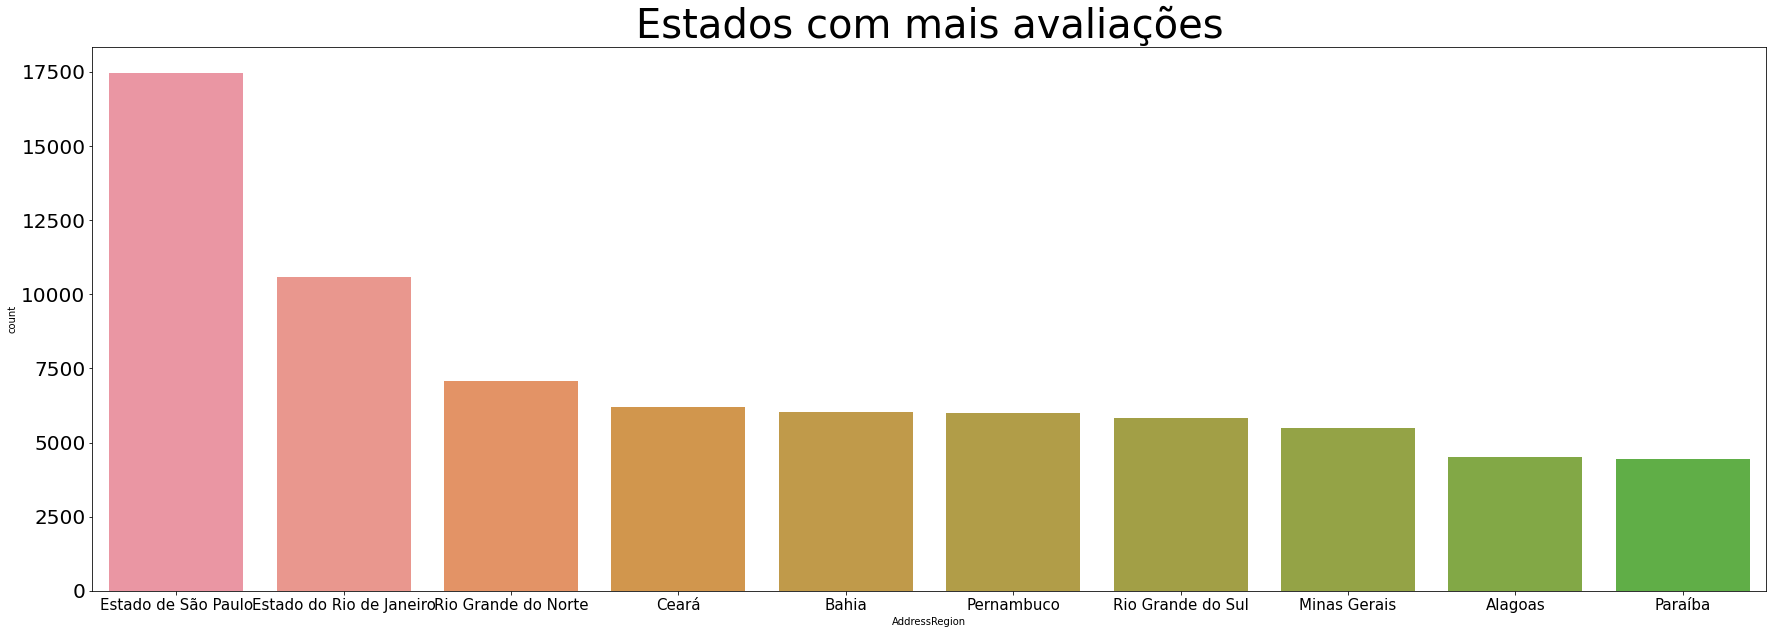

In [78]:
fig = plt.figure(figsize=(30,10)) 
sns.countplot(x='AddressRegion',order = df['AddressRegion'].value_counts().index, data=df)
plt.title('Estados com mais avaliações',fontsize=40)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.xlim(-0.5,9.5)


In [ ]:
sns.countplot(dados.groupby('publicationDate').userLocation.count());

In [ ]:
dados.groupby('userLocation').averageRating.count().plot()

In [ ]:
sns.countplot(dados.averageRating);

In [ ]:
sns.countplot(dados.ratingValue);

In [ ]:
sns.catplot(x="mobileDevice", kind="count", palette="ch:.25", data=dados)

### 4. Analise dos Sentimentos 

In [ ]:
def translateByTextBlob():
  dic2 = pd.DataFrame(dados)
  dic2['reviewBody']
  count = 0
  for _x in dic2['reviewBody']:
      count = count + 1  
      print(type(_x))
      x = _x.encode('utf-16', 'surrogatepass').decode('utf-16')
      print(x)
      
      print(count) #vai imprimir todos os reviews= 
          
      comentario_blob = TextBlob(x)
      print(type(comentario_blob))
      comentario_blob_us = comentario_blob.translate(to='us')

      for sentence_br, sentence in zip(comentario_blob.sentences, comentario_blob_us.sentences):
          print(sentence_br, ':', sentence.sentiment.subjectivity)
      if count == 5:
          print('**End**')
          break  

In [ ]:
translateByTextBlob()